In [52]:
"""Librairies nécessaires"""
import pandas as pd
from pandas import json_normalize
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt

import json

import geopy.distance
from geopy.distance import geodesic

from shapely.geometry import Point
from shapely.ops import nearest_points

from tqdm import tqdm

In [18]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A')

In [75]:
"""Création du fichier hopital df_hp"""

#lecture du fichier
emplacement = 'Enrichissement données/Données/Etablissements_hospitaliers_franciliens.json'
df_hp = json.load(open(emplacement))
df_hp = json_normalize(df_hp)

#variables d'intérêt
var_int = ['fields.categorie_de_l_etablissement',
       'fields.raison_sociale_entite_juridique', 'fields.adresse_complete',
       'fields.type_etablissement', 'fields.cp_ville', 'fields.dept',
       'fields.wgs84', 'fields.raison_sociale', 'fields.lat', 'fields.num_dept',
       'geometry.type', 'geometry.coordinates']

#ne garder que les variables d'intérêt
df_hp = df_hp.loc[:, var_int]
df_hp.head()

#ne garder que les types d'établissemenet et les départements intéressants
type_hp = ['Centre Hospitalier (C.H.)', 'Centre hospitalier, ex Hôpital local', 'Centre Hospitalier Régional (C.H.R.)']
list_dep = [75, 92, 93, 94]
df_hp = df_hp.loc[df_hp['fields.categorie_de_l_etablissement'].isin(type_hp)]
df_hp = df_hp.loc[df_hp['fields.num_dept'].isin(list_dep)]

#on change le format de la latitude et on ne garde que les établissements qui sont bien localisés
df_hp['fields.lat'] = df_hp['fields.lat'].astype(float)
df_hp = df_hp.loc[df_hp['fields.lat']>0]

#on renomme la colonne contenant la latitude
df_hp = df_hp.rename(columns={'fields.lat': 'latitude'})

#on ajoute la colonne contenant la longitude
df_hp['longitude'] = df_hp['fields.wgs84'].apply(lambda coord: coord[1] if coord else None)

#On créée une colonne geometry
df_hp['geometry'] = [Point(xy) for xy in zip(df_hp['longitude'], df_hp['latitude'])]

#On convertit en geodataframe
geo_df_hp = gpd.GeoDataFrame(df_hp, geometry='geometry')

#on ajoute un format aux coordonnées
geo_df_hp.crs = 'WGS 84'

geo_df_hp.head()

,fields.categorie_de_l_etablissement,fields.raison_sociale_entite_juridique,fields.adresse_complete,fields.type_etablissement,fields.cp_ville,fields.dept,fields.wgs84,fields.raison_sociale,latitude,fields.num_dept,geometry.type,geometry.coordinates,longitude,geometry
19,Centre Hospitalier (C.H.),"FOYER DE POST-CURE ET HOPITAL DE NUIT "" LES GO...",2 R DES GOULVENTS,Centres Hospitaliers,92000 NANTERRE,HAUTS-DE-SEINE,"[48.8903182, 2.1905973]",FOYER DE POST-CURE HOP. DE NUIT,48.890318,92,Point,"[2.1905973, 48.8903182]",2.190597,POINT (2.19060 48.89032)
20,Centre Hospitalier (C.H.),CENTRE THOMAS LEMAITRE + SERVICE SOINS INFIRMI...,9 R THOMAS LEMAITRE,Centres Hospitaliers,92000 NANTERRE,HAUTS-DE-SEINE,"[48.8889167, 2.1933446]",CENTRE THOMAS LEMAITRE,48.888917,92,Point,"[2.1933446, 48.8889167]",2.193345,POINT (2.19334 48.88892)
31,Centre Hospitalier (C.H.),CHI COURBEVOIE-NEUILLY-PUTEAUX SITE COURBEVOIE,30 R KILFORD,Centres Hospitaliers,92401 COURBEVOIE CEDEX,HAUTS-DE-SEINE,"[48.9010026, 2.2535691]",CHICNP - SITE COURBEVOIE,48.901003,92,Point,"[2.2535691, 48.9010026]",2.253569,POINT (2.25357 48.90100)
72,Centre Hospitalier Régional (C.H.R.),HOP LARIBOISIERE GH SAINT-LOUIS-LARIBOISIERE-F...,2 R AMBROISE PARE,Centres Hospitaliers Régionaux,75475 PARIS CEDEX 10,PARIS,"[48.8819273, 2.3527289]",HOPITAL LARIBOISERE,48.881927,75,Point,"[2.3527289, 48.8819273]",2.352729,POINT (2.35273 48.88193)
76,Centre Hospitalier Régional (C.H.R.),GPE HOSP LARIBOISIERE-FERNAND WIDAL-GPT HOSP U...,200 R FAUBOURG SAINT-DENIS,Centres Hospitaliers Régionaux,75010 PARIS,PARIS,"[48.8817067, 2.3584552]",GPE HOSP LARIBOISIERE-FERNAND WIDAL,48.881707,75,Point,"[2.3584552, 48.8817067]",2.358455,POINT (2.35846 48.88171)


In [6]:
"""Données administratives de Paris intra muros"""
paris_arrondissement = download_vectorfile_url_all(
    crs = 4326,
    values = ["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

"""Données administratives Ile de France"""
idf = download_vectorfile_url_all(
      values = "11",
      crs = 4326,
      borders = "DEPARTEMENT",
      vectorfile_format="topojson",
      filter_by="REGION",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

"""Données administrative de la petite couronne de Paris"""
petite_couronne = download_vectorfile_url_all(
    crs = 4326,
    values = ["75", "92", "93", "94"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 40.1kiB [00:00, 21.9MiB/s]
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


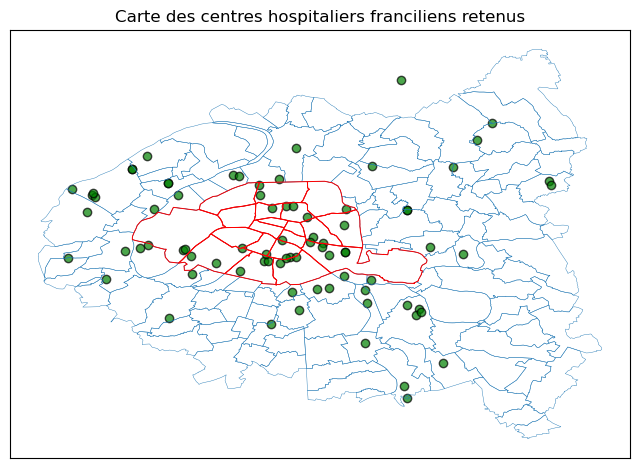

In [15]:
"""Visualisation des établissements hospitaliers"""

fig, ax = plt.subplots(figsize=(8, 7))

petite_couronne.boundary.plot(ax=ax, linewidth = 0.3) #on plot les frontières de la petite couronne

paris_arrondissement.boundary.plot(ax=ax, edgecolor = "red", linewidth = 0.7) #on ajout les arrondissements parisiens en rouge

geo_df_hp.plot(ax=ax, color='green', alpha=0.7, edgecolor='black', linewidth=1) #on ajoute les hopitaux

#rien sur les axes
plt.xticks([], [])
plt.yticks([], [])

#titre
plt.title('Carte des centres hospitaliers franciliens retenus')
plt.show()

In [11]:
"""Première fonction "naïve" pour ajouter la distance minimale aux hopitaux"""

def ajouter_dist_hopitaux(emplacement, année):
    #emplacement (string) : emplacement du fichier dvf auquel on veut ajouter l'information 
    
    df = pd.read_csv(emplacement, low_memory=False) #lecture du fichier

    df['dist_min_hopital']=0.0 #initialisation de la distance

    #on ne garde que les appartements qui sont localisés
    df = df.loc[(df['longitude']>0)&(df['latitude']>0)]

    #on va trouver pour chaque appartement l'hopital le plus proche et ajouter la distance
    for ind in df.index.tolist():

        #récupérer les coordonnées de l'appartement
        long = df.loc[ind]['longitude']
        lat = df.loc[ind]['latitude']
        coord_app = [lat, long] 

        #trouver la distance la plus faible
        dist = 100 #initialisation de la distance
        for hp in df_hp.index.tolist():
            d = GD(coord_app, df_hp.loc[hp]['fields.wgs84']).km
            if d<dist:
                dist=d
            else:
                pass

        #on met à jour la distance minimale
        df.loc[ind, 'dist_min_hopital']=dist

    nom_sortie = f"Enrichissement données/DVF_{année}_ajout_hopital.csv"
    df.to_csv(nom_sortie)

In [31]:
"""Appliquer la fonction au fichier 2023"""
ajouter_dist_hopitaux('Données_clean/DVF_75_2023_clean.csv')

In [37]:
"""Vérification"""
df_test = pd.read_csv('Enrichissement données/dvf_ajout_hopital')
df_test.head()

,Unnamed: 0.1,Unnamed: 0,id_mutation,date_mutation,prix,type_local,nb_dépendances,surface_reelle_bati,surface_carrez,nombre_pieces_principales,...,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,longitude,latitude,dist_min_hopital
0,0,2,2023-543616,2023-01-04,140000.0,Appartement,0.0,18.0,18.75,1.0,...,RUE DE COURCELLES,2387,75017.0,75117,Paris 17e Arrondissement,75,75117000BG0053,2.298612,48.884255,2.488706
1,1,3,2023-543617,2023-01-05,400000.0,Appartement,0.0,43.0,43.80,1.0,...,RUE TURGOT,9508,75009.0,75109,Paris 9e Arrondissement,75,75109000BD0036,2.345859,48.880564,0.372421
2,2,5,2023-543619,2023-01-03,295000.0,Appartement,0.0,28.0,NaN,2.0,...,RUE EMILE LEVEL,3246,75017.0,75117,Paris 17e Arrondissement,75,75117000DG0040,2.318419,48.893075,0.961064
3,3,7,2023-543620,2023-01-03,300400.0,Appartement,1.0,36.0,36.11,2.0,...,BD BARBES,0662,75018.0,75118,Paris 18e Arrondissement,75,75118000BV0098,2.349162,48.891187,1.062455
4,4,13,2023-543623,2023-01-04,213000.0,Appartement,1.0,27.0,NaN,1.0,...,RUE BOUCRY,1139,75018.0,75118,Paris 18e Arrondissement,75,75118000CW0057,2.362369,48.894577,1.459770


In [76]:
"""Fonction optimisée"""

def ajouter_hopitaux2(dvf, df_hopitaux):
    
    #dvf : geodataframe contenant la localisation de l'appartement dans une colonne 'geometry' au format WSG84
    #df_transport : geodataframe contenant la localisation des hopitaux dans une colonne 'geometry' au format WSG84

    #la fonction ajoute trois colonnes à dvf : closest_hopital, dist_min_hopital
    
    # Convertir la colonne 'geometry' en type Point
    dvf['geometry'] = dvf['geometry'].apply(Point)
    df_hopitaux['geometry'] = df_hopitaux['geometry'].apply(Point)
    
    # Définir la projection équidistante (EPSG:3395)
    dvf = dvf.to_crs(epsg=3395)
    df_hopitaux = df_hopitaux.to_crs(epsg=3395)
        
    # Fonction pour trouver la station de métro la plus proche
    def find_nearest_hospital(row):
        nearest_hospital = df_hopitaux.geometry == nearest_points(row['geometry'], df_hopitaux.unary_union)[1]
        return pd.Series({
            'closest_hopital': df_hopitaux.loc[nearest_hospital, 'fields.raison_sociale_entite_juridique'].values[0],
            'dist_min_hopital': row['geometry'].distance(df_hopitaux.loc[nearest_hospital, 'geometry'].values[0]) / 1000,  # Conversion en kilomètres
        })
    
    # Appliquer la fonction pour chaque appartement
    tqdm.pandas()  # Barre de progression pour les itérations
    dvf[['closest_hopital', 'dist_min_hopital']] = dvf.progress_apply(find_nearest_hospital, axis=1)

    # Reconvertir en WGS 84 (EPSG:4326)
    dvf_result = dvf.to_crs(epsg=4326)
    
    return dvf_result

In [46]:
emplacement_dvf = 'Données_clean/DVF_75_2023_clean.csv'

dvf = pd.read_csv(emplacement_dvf, low_memory=False, index_col=0)

dvf = gpd.GeoDataFrame(
        dvf, geometry=gpd.points_from_xy(dvf.longitude, dvf.latitude), crs="WGS84"
        )
dvf = dvf.head(100)

In [47]:
dvf_hp_test = ajouter_hopitaux2(dvf, geo_df_hp)
dvf_hp_test.head()

/opt/mamba/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/mamba/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
100%|██████████| 100/100 [00:00<00:00, 130.29it/s]


,id_mutation,date_mutation,prix,type_local,nombre_dependances,surface_reelle_bati,surface_carrez,nombre_pieces_principales,prix_au_m2_carrez,prix_au_m2_reel,...,code_postal,code_commune,nom_commune,code_departement,id_parcelle,longitude,latitude,geometry,closest_hopital,dist_min_hopital
0,2023-543616,2023-01-04,140000.0,Appartement,0.0,18.0,18.75,1.0,7467.0,7778.0,...,75017.0,75117,Paris 17e Arrondissement,75,75117000BG0053,2.298612,48.884255,POINT (2.29861 48.88426),HOPITAL GERIATRIQUE BRETONNEAU ( AP- HP ),3.777680
1,2023-543617,2023-01-05,400000.0,Appartement,0.0,43.0,43.80,1.0,9132.0,9302.0,...,75009.0,75109,Paris 9e Arrondissement,75,75109000BD0036,2.345859,48.880564,POINT (2.34586 48.88056),CLINIQUE DENTAIRE JEAN DELIBERO,0.565226
3,2023-543619,2023-01-03,295000.0,Appartement,0.0,28.0,NaN,2.0,NaN,10536.0,...,75017.0,75117,Paris 17e Arrondissement,75,75117000DG0040,2.318419,48.893075,POINT (2.31842 48.89308),HOPITAL GERIATRIQUE BRETONNEAU ( AP- HP ),1.458955
5,2023-543620,2023-01-03,300400.0,Appartement,1.0,36.0,36.11,2.0,8319.0,8344.0,...,75018.0,75118,Paris 18e Arrondissement,75,75118000BV0098,2.349162,48.891187,POINT (2.34916 48.89119),HOP LARIBOISIERE GH SAINT-LOUIS-LARIBOISIERE-F...,1.612700
11,2023-543623,2023-01-04,213000.0,Appartement,1.0,27.0,NaN,1.0,NaN,7889.0,...,75018.0,75118,Paris 18e Arrondissement,75,75118000CW0057,2.362369,48.894577,POINT (2.36237 48.89458),GPE HOSP LARIBOISIERE-FERNAND WIDAL-GPT HOSP U...,2.215855


In [77]:
"""Ma première fonction, (très) optimisée"""

def ajouter_dist_hopitaux3(gdf, gdf_hopitaux):

    gdf['dist_min_hopital'] = gdf.apply(lambda row: min(
     geodesic((row['latitude'], row['longitude']), (hp['latitude'], hp['longitude'])).km
    for _, hp in gdf_hopitaux.iterrows()
    ), axis=1)

    return gdf

In [54]:
dvf_hp_2 = ajouter_dist_hopitaux3(dvf, geo_df_hp)
dvf_hp_2.head()

,id_mutation,date_mutation,prix,type_local,nombre_dependances,surface_reelle_bati,surface_carrez,nombre_pieces_principales,prix_au_m2_carrez,prix_au_m2_reel,...,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,longitude,latitude,geometry,dist_min_hopital
0,2023-543616,2023-01-04,140000.0,Appartement,0.0,18.0,18.75,1.0,7467.0,7778.0,...,2387,75017.0,75117,Paris 17e Arrondissement,75,75117000BG0053,2.298612,48.884255,POINT (2.29861 48.88426),2.488706
1,2023-543617,2023-01-05,400000.0,Appartement,0.0,43.0,43.80,1.0,9132.0,9302.0,...,9508,75009.0,75109,Paris 9e Arrondissement,75,75109000BD0036,2.345859,48.880564,POINT (2.34586 48.88056),0.372421
3,2023-543619,2023-01-03,295000.0,Appartement,0.0,28.0,NaN,2.0,NaN,10536.0,...,3246,75017.0,75117,Paris 17e Arrondissement,75,75117000DG0040,2.318419,48.893075,POINT (2.31842 48.89308),0.961064
5,2023-543620,2023-01-03,300400.0,Appartement,1.0,36.0,36.11,2.0,8319.0,8344.0,...,0662,75018.0,75118,Paris 18e Arrondissement,75,75118000BV0098,2.349162,48.891187,POINT (2.34916 48.89119),1.062455
11,2023-543623,2023-01-04,213000.0,Appartement,1.0,27.0,NaN,1.0,NaN,7889.0,...,1139,75018.0,75118,Paris 18e Arrondissement,75,75118000CW0057,2.362369,48.894577,POINT (2.36237 48.89458),1.459770


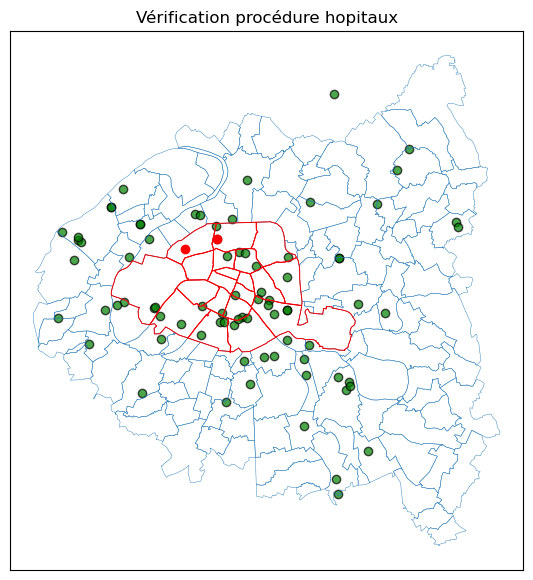

In [73]:
"""Vérification de la fonction"""

#on prend le premier appartement
appartement = dvf.index.tolist()[0] 

#on récupère les coordonnées de l'appartement
long = dvf.loc[appartement]['longitude']
lat = dvf.loc[appartement]['latitude']
coord_app = [long,lat]

#on récupère l'hopital qui était associé à cet appartement
hp_close = geo_df_hp.loc[geo_df_hp['fields.raison_sociale_entite_juridique']=='HOPITAL GERIATRIQUE BRETONNEAU ( AP- HP )']

#on récupère les coordonnées de l'appartement
longitude_hp = hp_close.geometry.x.iloc[0]
latitude_hp = hp_close.geometry.y.iloc[0]
coord_hp = [longitude_hp,latitude_hp]

#carte
fig, ax = plt.subplots(figsize=(8, 7))

petite_couronne.boundary.plot(ax=ax, linewidth = 0.3) #on plot les frontières de la petite couronne

paris_arrondissement.boundary.plot(ax=ax, edgecolor = "red", linewidth = 0.7) #on ajout les arrondissements parisiens en rouge

geo_df_hp.plot(ax=ax, color='green', alpha=0.7, edgecolor='black', linewidth=1) #on ajoute les hopitaux

ax.scatter(*coord_app, color='red', label='Appartement')
ax.scatter(*coord_hp, color='red', label='Hopital')


#rien sur les axes
plt.xticks([], [])
plt.yticks([], [])

#titre
plt.title('Vérification procédure hopitaux')
plt.show()